# Voxelized Ink Solver

Payton Goodrich

August 2021

(Description)

## Variable Glossary

The following cell is a summary of variables used and their corresponding data types

In [37]:
'''
Actual volume fraction of filler       float
Connectivity Matrix                    list of ints
Coordinates of node (x,y,z)            tuple of floats
Coordinates of point (x,y,z)           tuple of floats
Domain data                            dictionary
Friction contact parameter             float
Material data                          dictionary
Mapped coordinates of node (i,j,k)     tuple of ints       
Node ID                                int
Node size (dx, dy, dz) [m]             float
Number of nodes (Nx, Ny, Nz)           int
Particle data                          dictionary of floats
Particle ID                            int
Particle voxels                        list of ints
Target volume fraction of filler       float
Voxel ID                               int
''';

## User-input variables

Size of domain, particle data, etc.

In [38]:
domain = {   
    "Lx": (100e-6), # domain dimensions in x-direction [m]
    "Ly": (100e-6), # domain dimensions in y-direction [m]
    "Lz": (100e-6), # domain dimensions in z-direction [m]
    "Nx": 11, #number of nodes in x-direction
    "Ny": 11, #number of nodes in y-direction
    "Nz": 11, #number of nodes in z-direction
    "radiusMin": 1e-6, #minimum particle radius
    "radiusMax": 5e-6 #maximum particle radius
}

## Functions

The following cell is the beginning of the functions definition.  The functions definitions are broken into a few cells with markdowns preceding them to explain what the cell contains, just like I am doing here. 

In [39]:
import math
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
from numpy import random
from mpl_toolkits.mplot3d import Axes3D


def pickle_domain(domain):
    ''' 
    Saves the input domain object for later use. 
    Input:  File path    string
    Output: 
    '''
    filehandler = open('Saved_Data/Pickled_Data/pickled_domain.obj', 'wb')
    pickle.dump(domain, filehandler)
    # pickle.dumps(domain)

def unpickle_domain():
    '''
    Open a saved domain object from a file 
    Input:  File path    string
    Output: Domain       
    '''
    filehandler = open('Saved_Data/Pickled_Data/pickled_domain.obj', 'rb')
    
    return pickle.load(filehandler)


def distancefrom3DPoint(p1,p2):
    
    '''
    Calculates and returns the scalar distance between two points
    Input:  Point 1                    tuple of floats
            Point 2                    tuple of floats
    Output: Distance between points    float
    '''
    
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]
    z1 = p1[2]
    z2 = p2[2]
    
    ans = math.sqrt(((x2-x1)**2)+((y2-y1)**2)+((z2-z1)**2)) 
    
    return ans

def distancefrom2DPoint(p1,p2):
    
    '''
    Calculates and returns the scalar distance between two points
    Input:  Point 1                    tuple of floats
            Point 2                    tuple of floats
    Output: Distance between points    float
    '''
    
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]
    ans = math.sqrt(((x2-x1)**2)+((y2-y1)**2)) 
    
    return ans

def voxelSize(L, numberNodes):
    
    '''
    Generates the size of the edge of a cubic voxel in a cubic domain
    Input:  Length of the domain                    float
            Number of nodes in a direction          int
    Output: Length of a node                        float
    '''
    
    edgeLength = L/(numberNodes-1)
    
    return edgeLength

def discretizeDomain(domain):
    
    '''
    Generates a list of all voxels within a cubic domain
    Input:  Domain                            dictionary of domain info
    Output: List of node coordinates          list of tuples of floats
            List of mapped node coordinates   list of tuples of ints
    '''
    
    #Unpack domain into variables for clarity
    Lx = domain["Lx"]
    Ly = domain["Ly"]
    Lz = domain["Lz"]
    Nx = domain["Nx"]
    Ny = domain["Ny"]
    Nz = domain["Nz"]
    
    #Calculate x,y,z edge length of a voxel
    dx = voxelSize(Lx,Nx)
    dy = voxelSize(Ly,Ny)
    dz = voxelSize(Lz,Nz)
    
    #Calculate the coordinates for each node, sequentially
    nodeCoords = []
    nodeMappedCoords = []
    for k in range(0,Nz):
        for j in range(0,Ny):
            for i in range(0,Nx):
                
                #Coordinates
                x = i * dx
                y = j * dy
                z = k * dz
                
                #Append List
                nodeCoords.append((x,y,z))
                nodeMappedCoords.append((i,j,k))
                
    return nodeCoords,nodeMappedCoords

def voxelizeDomain(domain):
   
    '''
    Generates a connectivity matrix for cubic voxels
    Input:  Domain                               dictionary of domain info
    Output: The connectivity matrix              list of tuples of ints        
    '''
    
    #Unpack domain into variables for clarity
    Nx = domain["Nx"]
    Ny = domain["Ny"]
    Nz = domain["Nz"]
    
    #Initialize Connectivity Matrix Calculation
    y_row = 1
    z_layer = 1
    connectivityMatrix = [] #connectivity matrix
    
    for i in range(1,((Nx-1)*(Ny-1)*(Nz-1))+1): #for each voxel...
        
        n0 = i + ((z_layer-1)*((Nx-1)+(Ny-1)+1)) + (y_row-1) #first node in the voxel.  Everything else follows.
        
        
        connectivityMatrix.append((n0, \
                          n0+1, \
                          n0+(Nx-1)+2, \
                          n0+(Nx-1)+1, \
                          n0+((Nx-1)+1)*((Ny-1)+1), \
                          n0+((Nx-1)+1)*((Ny-1)+1)+1, \
                          n0+((Nx-1)+1)*((Ny-1)+1)+(Nx-1)+2, \
                          n0+((Nx-1)+1)*((Ny-1)+1)+(Nx-1)+1))
        
        #Test for next row (y-direction) or next layer (z-direction) of voxels
        nextRow = (i)%(Nx-1)
        nextLayer = (i)%((Nx-1)*(Ny-1))
        
        if np.isclose(nextRow,0) == True:
            y_row += 1
            
        if np.isclose(nextLayer,0) == True:
            z_layer = z_layer+1
            y_row = 1
    
    return connectivityMatrix
    
def plotParticleVoxels(domain, nodeMappedCoords, particleVoxels):
    '''
    Generates a plot of all particle voxels. 
    Note - Currently only works with cube shaped domain.  Must modify following for non-cubes: 
    x,y,z = np.indices((Nx,Ny,Nz))*dx
    
    Input: Domain                                            dictionary of domain info
           List of mapped node coordinates                   list of tuples of ints
           List of voxels that are on the particle list      list of tuples of ints
    Output: 
    '''

    #Unpack domain into variables for clarity
    Lx = domain["Lx"]
    Ly = domain["Ly"]
    Lz = domain["Lz"]
    Nx = domain["Nx"]
    Ny = domain["Ny"]
    Nz = domain["Nz"]
    
    #Calculate x,y,z edge length of a voxel
    dx = voxelSize(Lx,Nx)
    dy = voxelSize(Ly,Ny)
    dz = voxelSize(Lz,Nz)
    
    plottingNodes = np.zeros((Nx-1,Ny-1,Nz-1))
    
    for i in range(len(particleVoxels)): #for each voxel in the list of particle voxels
            
        thisVoxelNumber = particleVoxels[i] #this voxel number
        thisNodeNumber = connectivityMatrix[thisVoxelNumber][0] #(0,0,0) node of voxel
#         thisNodesCoords = nodeNumber2Coords(thisNodeNumber,nodeCoords) #coords of (0,0,0) node of voxel
        thisNodesMappedCoords = nodeNumber2MappedCoords(thisNodeNumber,nodeMappedCoords)
        plottingNodes[thisNodesMappedCoords] = True
    

    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('auto')
    
    # Map back to geometric coordinates. Only works if cube shaped domain.
    x,y,z = np.indices((Nx,Ny,Nz))*dx
    ax.voxels(x,y,z,plottingNodes, edgecolor="k")

    return plottingNodes
  
    
def nodeNumber2MappedCoords(nodeNumber,nodeMappedCoords):
    '''
    Generates a x,y,z coordinate in [m] from a node number 
    Input: Node number of query                        int
           List of mapped node coordinates             list of tuples of ints
    Output: mapped coordinates of node                 tuple of ints
    '''
    
    (i,j,k) = nodeMappedCoords[nodeNumber-1]
    
    return (i,j,k)

def nodeNumber2Coords(nodeNumber,nodeCoords):
    '''
    Generates a x,y,z coordinate in [m] from a node number 
    Input: Node number of query                 int
           List of node coordinates             list of tuples of floats
    Output: x,y,z coordinates [m] of node       tuple of floats
    '''
    
    thisNodesCoordinates = nodeCoords[nodeNumber-1]
    
    return thisNodesCoordinates
    

def voxelizeSphere(A, r):    
    
    '''
    Generates the a list of all nodes within the distance, r, from a point, A
    Input:  Point A                    tuple of ints
            r                          tuple of ints
    Output: List of voxels             list of tuples of ints
    '''
    
    P = []
    
    for x in range(A[0]-r-1,A[0]+r+1):
        for y in range(A[1]-r-1,A[1]+r+1):
            for z in range(A[2]-r-1,A[2]+r+1):
                if distancefrom3DPoint((x,y,z),A)<=r:
                    P.append((x,y,z))
                
    return P

# def contactForces():
#     '''
#     Calculate the particle-to-particle forces
#     Input:  Compliance constant               float
#             Contact area parameter            float
#             Particles data                    dictionary of floats           
#     Output: Particle contact force            float
#     '''
#     pass

# def newPositions():
#     '''
#     Calculate the new particle positions from the contact forces
#     Input:  Compliance constant               float
#             Contact area parameter            float
#             Particle contact force            float
#             Particles data                    dictionary of floats
            
#     Output: Particle contact force            float
#     '''
#     pass

def calculate_Vf():
    '''
    Calculate the volume fraction of filler particles
    Input:  Nodes data                        dictionary of floats
            Particles data                    dictionary of floats
            
    Output: Actual volume fraction of filler  float
    '''
    pass

def generateParticle(xmax,xmin,ymax,ymin,zmax,zmin,rmax,rmin):
    '''
    Define the centroid of a particle and the particle size
    Input:  Particles data                     dictionary of floats
    Output: Particle centroid and radius       tuples of floats
    '''
    
    #generate a random x-coordinate
    phi = random.rand() #random number 0-1
    xi = int(round(phi*(xmax-xmin)+xmin)) #pick random x-coordinate within xmin:xmax

    #generate a random y-coordinate
    phi = random.rand() #random number 0-1
    yi = int(round(phi*(ymax-ymin)+ymin)) #pick random y-coordinate within ymin:ymax
   
    #generate a random z-coordinate
    phi = random.rand() #random number 0-1
    zi = int(round(phi*(zmax-zmin)+zmin)) #pick random y-coordinate within ymin:ymax
    
    #generate a random particle radius
    phi = random.rand() #random number 0-1
    ri = int(round(phi*(rmax-rmin)+rmin)) #pick random y-coordinate within ymin:ymax
    
    return(xi,yi,zi,ri)

# def calculateAij():
#     pass
        

## Function Testing

Below is a test space for functions that I am writing

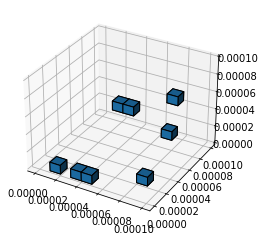

In [40]:
'''
TEST THE FUNCTIONS
'''

# discretizeDomain
nodeCoords, nodeMappedCoords = discretizeDomain(domain)
# print(len(nodeCoords))
# print(type(nodeCoords))
# print(nodeCoords[0])
# print(nodeCoords[1])
# print(nodeCoords[456])
# print(nodeCoords)
# print(nodeMappedCoords)

# voxelizeDomain
connectivityMatrix = voxelizeDomain(domain)
# print(len(connectivityMatrix))
# print(type(connectivityMatrix))
# print(connectivityMatrix[0][0])
# print(type(connectivityMatrix[7][5]))
# print(connectivityMatrix)

# plotVoxelizedDomain
particleVoxels = [1, 3, 4, 28, 187, 555, 678, 554]
plottingNodes = plotParticleVoxels(domain, nodeMappedCoords, particleVoxels)

## distancefrom2DPoint
# test = distancefrom3DPoint((3,0),(0,4))
# print(test)
# type(test)

## distancefrom3DPoint
# test = distancefrom3DPoint((3,0,0),(0,4,0))
# print(test)
# type(test)


## sphereVoxels
# r = 1
# A = (0,0,0)
# test = sphereVoxels(A,r)
# print(test)
# print(test[2])
# type(test)



In [19]:
Nx = 3
Ny = 3
Nz = 3
dx = 0.5
x,y,z = np.indices((Nx,Ny,Nz))*dx 
print(x)
type(x)

[[[0.  0.  0. ]
  [0.  0.  0. ]
  [0.  0.  0. ]]

 [[0.5 0.5 0.5]
  [0.5 0.5 0.5]
  [0.5 0.5 0.5]]

 [[1.  1.  1. ]
  [1.  1.  1. ]
  [1.  1.  1. ]]]


numpy.ndarray

In [ ]:
"""
===============================
3D voxel plot of the numpy logo
===============================

Demonstrates using `.Axes3D.voxels` with uneven coordinates.
"""

import matplotlib.pyplot as plt
import numpy as np


def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

# build up the numpy logo
n_voxels = np.zeros((4, 3, 4), dtype=bool)
n_voxels[0, 0, :] = True
n_voxels[-1, 0, :] = True
n_voxels[1, 0, 2] = True
n_voxels[2, 0, 1] = True
facecolors = np.where(n_voxels, '#FFD65DC0', '#7A88CCC0')
edgecolors = np.where(n_voxels, '#BFAB6E', '#7D84A6')
filled = np.ones(n_voxels.shape)

# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

# Shrink the gaps - this makes it so all faces are drawn
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.05
y[:, 0::2, :] += 0.05
z[:, :, 0::2] += 0.05
x[1::2, :, :] += 0.95
y[:, 1::2, :] += 0.95
z[:, :, 1::2] += 0.95

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)

# plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
N1 = 10
N2 = 10
N3 = 10
# ma = np.random.choice([0,1], size=(N1,N2,N3), p=[0.99, 0.01])
ma = 

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('auto')

ax.voxels(ma, edgecolor="k")

plt.show()

## Main Program

Below is the main program that calls on the functions to execute the objective.  In this case, fill a domain with spherical particles.

In [ ]:
start = time.perf_counter()

## SETUP PROBLEM
tic = time.perf_counter()
particleVoxels=[]




## Program testing

test the main program

## Plotting

Below is plotting the results

## Archive

To generate the particle coordinates and radius, I should use one of the two methods in the following cell.  The benefit of using a class is that I can call a new particle each time and can be flexibly used in future code.  The benefit of the function-only method is that it might be easier to do initially... but maybe not? Should get a second opinion perhaps.

In [ ]:
def generateParticle(xmax,xmin,ymax,ymin,zmax,zmin,rmax,rmin):
    '''
    Define the centroid of a particle and the particle size
    Input:  Particles data                     dictionary of floats
    Output: Particle centroid and radius       tuples of floats
    '''
    
    #generate a random x-coordinate
    phi = random.rand() #random number 0-1
    xi = int(round(phi*(xmax-xmin)+xmin)) #pick random x-coordinate within xmin:xmax

    #generate a random y-coordinate
    phi = random.rand() #random number 0-1
    yi = int(round(phi*(ymax-ymin)+ymin)) #pick random y-coordinate within ymin:ymax
   
    #generate a random z-coordinate
    phi = random.rand() #random number 0-1
    zi = int(round(phi*(zmax-zmin)+zmin)) #pick random y-coordinate within ymin:ymax
    
    #generate a random particle radius
    phi = random.rand() #random number 0-1
    ri = int(round(phi*(rmax-rmin)+rmin)) #pick random y-coordinate within ymin:ymax
    
    return(xi,yi,zi,ri)

class particle:
    def __init__(self, particleData):
        '''
        An object with centroid coordinates and particle radius
        Input:  Particles data                     dictionary of floats
        Output: Particle centroid and radius       tuples of floats
        '''
        
        self.xmin = particleData["xmin"]
        self.xmax = particleData["xmax"]
        self.ymin = particleData["ymin"]
        self.ymax = particleData["ymax"]
        self.zmin = particleData["zmin"]
        self.zmax = particleData["zmax"]
        self.rmin = particleData["rmin"]
        self.rmax = particleData["rmax"]
        
    def centroidCoordinates(self):
        #generate a random x-coordinate
        phi = random.rand() #random number 0-1
        xi = int(round(phi*(xmax-xmin)+xmin)) #pick random x-coordinate within xmin:xmax

        #generate a random y-coordinate
        phi = random.rand() #random number 0-1
        yi = int(round(phi*(ymax-ymin)+ymin)) #pick random y-coordinate within ymin:ymax
   
        #generate a random z-coordinate
        phi = random.rand() #random number 0-1
        zi = int(round(phi*(zmax-zmin)+zmin)) #pick random z-coordinate within zmin:zmax
    
    
        return(xi,yi,zi)
    
    def particleRadius(self):
        #generate a random particle radius
        phi = random.rand() #random number 0-1
        ri = int(round(phi*(rmax-rmin)+rmin)) #pick random radius within rmin:rmax
        
        return(ri)

In [ ]:
class fillDomain:
    ''' An object with domain data.'''
    def __init__(self, initialize_domain):
        '''
        Initialize and run the domain filling algorithm
        Input:  
        Output: 
        '''
        start = time.perf_counter()
        ## SETUP PROBLEM
            
        particleData = {
            "xmin": 0
            "xmax": 50e-6
            "ymin": 0
            "ymax": 50e-6
            "zmin": 0
            "zmax": 50e-6
            "rmin": 3e-6
            "rmax": 6e-6
        }
        
        numberNodes = 21
        
        
        if initialize_domain:
            tic = time.perf_counter()
            domain = "volume of interest in x,y,z"
            pickle_domain(domain)
            toc = time.perf_counter()
            print(f"Domain initialized and pickled in {toc - tic:0.4f} seconds")
        # domain.save_domain_data()
        else:
            domain = unpickle_domain()
            print('Domain was unpickled.')
            print('x =', domain.x)
            print('y =', domain.y)
            print('z =', domain.z)
            
        ## SET INITIAL CONDITIONS

## Beginning of Nico's Code

This framework for this code was developed by Nicolas Castrillon in 2020.

In [ ]:
# import SLS_problem
# import domain2D
import pickle
import numpy as np
import time
from math import pi, exp, sin, acos, ceil, floor
from statistics import mean
import csv
from tqdm import tqdm


def pickle_domain(domain):
	''' Saves the input domain object for later use. '''
	filehandler = open('Saved_Data/Pickled_Data/pickled_domain.obj', 'wb')
	pickle.dump(domain, filehandler)
	# pickle.dumps(domain)


def unpickle_domain():
	''' Opens a saved domain object. '''
	filehandler = open('Saved_Data/Pickled_Data/pickled_domain.obj', 'rb')
	return pickle.load(filehandler)


def density(T, material='nylon_six'):
	if material == 'nylon_six':
		return 1090.513  # [kg/m^3] densities of the amorphous and each crystalline phase [amorphous, alpha, gamma, gamma*], from Illiers
	elif material == 'stainless_three_sixteen_L':
		# based on Ganeriwala & Zohdi, Table 1
		T_points = [293, 366, 478, 589, 700, 811, 922, 1033, 1144, 1255, 1700]
		property_points = [7952, 7919, 7877, 7831, 7786, 7739, 7692, 7640, 7587, 7537, 7300]
		return np.interp(T, T_points, property_points)  # [kg/m^3]


def heat_capacity(T, material='nylon_six'):
	'''
	Calculates temperature-dependent heat capacity.
	Input:  Temperature [K]            float
	Output: Heat capacity [J/(kg-K)]   float
	'''
	if material == 'nylon_six':
		# PA6 is semicrystalline; step-changes of Cp only occur at Tg (~320K), not Tm (~493K)
		# Lm = (-3.03 + 1.8406 * T - 0.001577 * T**2) * 1000  # [J/kg] from Millot, Eqn 4, based on Eqns 2 & 3
		return (0.001348 * T + 1.9793) * 1000  # [J/(kg-K)]  heat capacity for range T=[320,600]K (Tg and above), from Millot Eqn 2
	elif material == 'stainless_three_sixteen_L':
		# based on Ganeriwala & Zohdi, Table 1
		T_points = [293, 366, 478, 589, 700, 811, 922, 1033, 1144, 1255, 1700]
		property_points = [452, 485, 527, 548, 565, 573, 586, 615, 649, 690, 815]
		return np.interp(T, T_points, property_points)  #[J/(kg-K)]


def extinction_coefficient(volfrac, powder_depth):
	'''
	Calculates the extinction coefficient for the Beer-Lambert equation.
	Input:  Volume fraction of powder layer  float
					Length scale                     float
	Output: Extinction coefficient           float
	'''
	# print(f"D     = {powder_depth}, {type(powder_depth)}")
	# print(f"volfrac = {volfrac}, {type(volfrac)}")
	beta = 3 * volfrac / ( 2 * (1 - volfrac) * (2 * powder_depth) )
	return beta


def conductivity(T, Tm, material='nylon_six'):
	'''
	Calculates temperature-dependent thermal conductivity.
	Input:  Temperature [K]         float
	Output: Melting temperature [K] float
	'''
	# Keating & McLaren (1990) Table 1 - extrapolated based on Nylon 6 data
	if material == 'nylon_six':
		if T > Tm:
			return -0.746 + 0.002 * T  # [W/m-K]
		else:
			return 0.23
	elif material == 'stainless_three_sixteen_L':
		# based on Ganeriwala & Zohdi, Table 1
		T_points = [293, 366, 478, 589, 700, 811, 922, 1033, 1144, 1255, 1700]
		property_points = [13.3, 14.3, 15.9, 17.5, 19.0, 19.8, 21.9, 23.2, 24.6, 26.2, 32.4]
		return np.interp(T, T_points, property_points)  #[W/m-K]


def load_ICs(particles, nodes, x, y, z, Ts, Tp):
	'''
	Load the initial conditions for the powder layer and the substrate.
	Input:  Particles data                      dictionary of floats
					Nodes data                          dictionary of floats
					Substrate x-axis discretization [m] numpy array
					Substrate y-axis discretization [m] numpy array
					Substrate z-axis discretization [m] numpy array
					Initial substrate temperature [K]   float
					Initial particles temperature [K]   float
	'''
	for p in particles:
		particles[p]['temp'] = Tp
	for i in range(len(x)):
		for j in range(len(y)):
			for k in range(len(z)):
				nodes[(x[i], y[j], z[k])]['temp'] = Ts


def initialize_max_temps(particles, x, y, z):
	'''
	initialized the dictionaries for local max temperatures at the nodes and the particles.
	Input:  Particles data                      dictionary of floats
					Substrate x-axis discretization [m] numpy array
					Substrate y-axis discretization [m] numpy array
					Substrate z-axis discretization [m] numpy array
	Output: Max temperature data of nodes       dictionary of floats
					Max temperature data of particles   dictionary of floats
	'''
	max_T_particles = {}
	max_T_nodes = {}
	for p in particles:
		max_T_particles[p] = 0.0
	for i in range(len(x)):
		for j in range(len(y)):
			for k in range(len(z)):
				max_T_nodes[(x[i], y[j], z[k])] = 0.0
	return max_T_nodes, max_T_particles


def temporal_domain(X, delta, material, laser_speed, laser_size, Ts, Tp, Tm):
	'''
	Calcualte the temporal domain based on the laser dynamics and the spatial domain.
	Input:  Max x-axis position [m]             float
					Node sizes (dx, dy, dz) [m]         tuple
					Material 														string
					Speed of laser [m/s]                float
					Radius of laser [m]                 float
					Initial substrate temperature [K]   float
					Initial particles temperature [K]   float
					Melting temperature [K]             float
	Output: Time discretization [s]             numpy array
					Time step size [s]                  float
	'''
	final_time = (X + 2 * laser_size) / laser_speed  # laser starts and ends 1 laser size away from domain boundary
	dx = min(delta)
	# max dt for particle dynamics
	rho = density(Tp, material)
	Cp_p = heat_capacity(Tp, material)
	K_p = conductivity(Tp, Tm, material)
	dt_max_p = rho * Cp_p * dx**2 / (6 * K_p)
	# max dt for nodal dynamics
	rho = density(Ts, material)
	Cp_n = heat_capacity(Ts, material)
	K_n = conductivity(Ts, Tm, material)
	dt_max_n = rho * Cp_n * dx**2 / (6 * K_n)
	# find max nt for stable explicit time integration scheme
	dt_max = min( dt_max_n, dt_max_p, final_time / 40 )
	nt = ceil(final_time / dt_max + 1)
	# print(f"dx = {dx} || final time = {final_time}  dt = {dt_max}  nt = {nt}")
	time, dt = np.linspace(0.0, final_time, nt, endpoint=True, retstep=True)
	# print('time stamps = ', time)
	return time, dt


def heat_transfer_term(particles, p, material, h, Te, Tm, eps, sig):
	'''
	Calculate the heat balance of particle p.
	Input:  Particles data                      dictionary of floats
					Particle ID                         int
					Convection coefficient [W/(m^2 K)]  float
					Temperature of the environment [K]  float
					Melting temperature [K]             float
					Emissivity                          float
					Stefan-Boltzmann [W/(m^2 K^4)]      float
	Output: Net heat transfer per second [W]    float
	'''
	# Qi in Ganeriwala Eqns 19 & 20
	p_coords = particles[p]['coords']
	p_radius = particles[p]['rad']
	p_contact = particles[p]['contacts']
	p_T = particles[p]['temp']
	projected_area = pi * p_radius**2
	p_cond = conductivity(p_T, Tm, material)
	conduction = 0.0
	for pc in p_contact:
		pc_coords = particles[pc]['coords']
		pc_radius = particles[pc]['rad']
		pc_T = particles[pc]['temp']
		K = ( p_cond + conductivity(pc_T, Tm, material) ) / 2
		d = domain2D.distance3D(p_coords, pc_coords)
		contact_area = pi * (p_radius * sin(acos( (pc_radius**2 - p_radius**2 - d**2) / (-2 * d * p_radius) )))**2
		conduction += K * (pc_T - p_T) / d * contact_area
		# print(f"conduction: {conduction} += {K} * {(pc_T - p_T) / d} * {contact_area}")
		# dT_dx = (pc_T - p_T) / d
		# print(f"dT/dx = {dT_dx}")
	convection = h * (Te - p_T) * projected_area
	# print(f"convection: {convection} = {h} * {(Te - p_T)} * {projected_area}")
	radiation = eps * sig * (Te**4 - p_T**4) * projected_area
	# print(f"radiation: {radiation} = {eps} * {sig} * {(Te**4 - p_T**4)} * {projected_area}")
	Q = conduction + convection + radiation
	# print(f"particle-particle: {abs(Q)} = {abs(conduction)} + {abs(convection)} + {abs(radiation)}")
	return Q


def laser_heating_particle(particles, p, volfrac, powder_depth, power, laser_center, laser_size, absorptivity):
	'''
	Calculate the energy absorbed by particle p due to its depth and the current position of the laser.
	Input:  Particles data                      dictionary of floats
					Particle ID                         int
					Volume fraction of powder layer     float
					Laser power setting [W]             float
					Position of center of laser [m]     float
					Radius of laser [m]                 float
					Absorptivity of material            float
	Output: Laser heat absorbed per second [W]  float
	'''
	# Hi in Ganeriwala Eqn 21-23
	p_coords = particles[p]['coords']
	p_radius = particles[p]['rad']
	min_powder_depth, max_powder_depth = powder_depth
	projected_area = pi * p_radius**2
	radial_distance = domain2D.distance2D(p_coords, laser_center)
	beta = extinction_coefficient(volfrac, max_powder_depth)
	I0 = 2 * power / (pi * laser_size**2)
	planar_distance_multiplier = exp(-2 * radial_distance**2 / laser_size**2)
	# if planar_distance_multiplier < exp(-2):
	# 	planar_distance_multiplier = 0.0
	# I = I0 * exp(-beta * p_coords[2]) * planar_distance_multiplier  # [W/m^2] local laser energy intensity
	depth_multiplier = exp(-beta * p_radius)
	I = I0 * planar_distance_multiplier * depth_multiplier  # [W/m^2] local laser energy intensity
	# I = I0 * planar_distance_multiplier  # [W/m^2] local laser energy intensity
	H = absorptivity * I * projected_area  # [W] total absorbed power by particle
	# print(f"laserheat: {abs(H)} = {absorptivity} * {I0} * {exp( -beta * p_coords[2] )} * {planar_distance_multiplier} * {projected_area}")
	particles[p]['Ipenetrated'] = (1 - absorptivity) * I  # [W/m^2] laser power that penetrates particle onto nodes
	# print(f"particle {H} W")
	# print(f"{p}  |  absorbed {H} = {absorptivity} * {I0} * exp({-beta} * {p_coords[2]}) * exp(-2 * {radial_distance**2} / {laser_size**2}) * {projected_area}")
	# print(f"           {H} = {absorptivity} * {I0} * exp({-beta * p_coords[2]}) * exp({-2 * radial_distance**2 / laser_size**2}) * {projected_area}")
	# print(f"           {H} = {absorptivity} * {I0} * {exp(-beta * p_coords[2]) * exp(-2 * radial_distance**2 / laser_size**2)} * {projected_area}")
	# print(f"           {H} = {absorptivity} * {I0 * exp(-beta * p_coords[2]) * exp(-2 * radial_distance**2 / laser_size**2)} * {projected_area}")
	return H


def update_particle_temps(particles, dt, material, h, Te, Tm, eps, sig, volfrac, powder_depth, power, laser_center, laser_size, absorptivity, max_T_particles):
	'''
	Integrate in time the temperature of all particles.
	Input:  Particles data                      dictionary of floats
					Time step size [s]                  float
					Material 														string
					Convection coefficient [W/(m^2 K)]  float
					Temperature of the environment [K]  float
					Melting temperature [K]             float
					Emissivity                          float
					Stefan-Boltzmann [W/(m^2 K^4)]      float
					Volume fraction of powder layer     float
					Laser power setting [W]             float
					Position of center of laser [m]     float
					Radius of laser [m]                 float
					Absorptivity of material            float
					Max temperature data of particles   dictionary of floats
	'''
	# Ganeriwala Eqn 18
	# print(f"    volfrac = {volfrac}")
	max_temp = 0.0
	new_particles = {}
	for p in particles:
		p_T = particles[p]['temp']
		p_radius = particles[p]['rad']
		p_vol = 4/3 * pi * p_radius**3
		rho = density(p_T, material)
		Cp = heat_capacity(p_T, material)
		Q = heat_transfer_term(particles, p, material, h, Te, Tm, eps, sig)
		H = laser_heating_particle(particles, p, volfrac, powder_depth, power, laser_center, laser_size, absorptivity)
		new_particles[p] = p_T + dt * (Q + H) / (rho * p_vol * Cp)  # kg/m^3 m^3 J/(kg-K) = J/K
		# print(f"Tnew_particles: {p} {new_particles[p]} = {p_T} + dt * {abs(Q + H)} / (rho * p_vol * Cp)")
		if new_particles[p] > max_temp:
			max_temp = new_particles[p]
	print(f"                         max particle temp is {max_temp}")
	for p in particles:
		T = new_particles[p]
		particles[p]['temp'] = T
		if T > max_T_particles[p]:
			max_T_particles[p] = T
	

def node_particle_cond(nodes, loc, particles, p, material, Tm):
	'''
	Calculate the heat conduction from particle p to a node in contact.
	Input:  Nodes data                        dictionary of floats
					Coordinates of node (x, y, z) [m] tuple
					Particles data                    dictionary of floats
					Particle ID                       int
					Material 													string
					Melting temperature [K]           float
	Output: Net heat conducted [W]           float
	'''
	n_T = nodes[loc]['temp']
	n_K = conductivity(n_T, Tm, material)
	p_T = particles[p]['temp']
	p_K = conductivity(p_T, Tm, material)
	length = particles[p]['rad']
	flux = -( (n_K + p_K) * (n_T - p_T) ) / (2 * length) * 0.25  #  [W] avg K times temp difference/rad; applies to 1/4 cell area
	# print(f" cond_particle: {flux} = -( {(n_K + p_K)} * {(n_T - p_T)} ) / (2 * {length} ) * 0.25")
	return flux


def heats_from_particles(nodes, particles, delta, x, y, z, material, Tm):
	'''
	Update the heat conducted from particles to nodes and the laser intensity that penetrates the particles down to the nodes.
	Input:  Nodes data                          dictionary of floats
					Particles data                      dictionary of floats
					Node sizes (dx, dy) [m]             tuple
					Substrate x-axis discretization [m] numpy array
					Substrate y-axis discretization [m] numpy array
					Substrate z-axis discretization [m] numpy array
					Material 														string
					Melting temperature [K]             float
	'''
	dx, dy = delta
	node_area = dx * dy
	nx = len(x)
	ny = len(y)
	# reset heat variable
	for i in range(len(x)):
		for j in range(len(y)):
			for k in range(len(z)):
				nodes[(x[i], y[j], z[k])]['p_heat'] = 0.0
	# Conduct heat and transmit laser energy from each particle to underlying nodes
	for p in particles:
		p_radius = particles[p]['rad']
		p_coords = particles[p]['coords']
		p_Ipenet = particles[p]['Ipenetrated']
		l, m = domain2D.locate_particle(particles[p]['coords'], delta)
		# Conduction from particle
		sq_coords = [ (x[l], y[m], z[-1]), (x[l + 1], y[m], z[-1]),
									(x[l + 1], y[m + 1], z[-1]), (x[l], y[m + 1], z[-1]) ]  # (x,y)-coords for corners enclosing particle
		for loc in sq_coords:
			heat = nodes[loc]['p_heat']
			nodes[loc]['p_heat'] = heat + node_particle_cond(nodes, loc, particles, p, material, Tm) * node_area
		# print(f"{p}  |  cond {nodes[loc]['p_heat']} W")
		# # PENETRATED LASER HEAT THROUGH PARTICLES TO NODES
		# ndx = int( ceil(p_radius / dx + 1) )  # define search box
		# ndy = int( ceil(p_radius / dy + 1) )
		# # print('p =', p, '  p index = ', l, m, '  ndx, ndy =', ndx, ndy)
		# bounds = [ max(0, l - ndx), min(l + ndx + 1, nx), max(0, m - ndy), min(m + ndy + 1, ny) ]  # index bounds
		# for i in range(int(bounds[0]), int(bounds[1])):
		# 	for j in range(int(bounds[2]), int(bounds[3])):
		# 		d = domain2D.distance2D((x[i], y[j]), p_coords)
		# 		if d <= p_radius:
		# 			for k in range(len(z)):
		# 				# depth = nodes[(x[i], y[j], z[k])]['depth']
		# 				# beta = extinction_coefficient(.99, p_radius)  # laser energy travelling through particle's vertical cord length
		# 				# depth_multiplier = exp(-beta * depth)
		# 				# nodes[(x[i], y[j], z[k])]['Ipenetrated'] = p_Ipenet * nodes[(x[i], y[j], z[k])]['occlusion']  # [W/m^2] penetrated intensity that hits node
		# 				# nodes[(x[i], y[j], z[k])]['Ipenetrated'] = p_Ipenet * depth_multiplier  # [W/m^2] penetrated intensity that hits node
		# 				nodes[(x[i], y[j], z[k])]['Ipenetrated'] = p_Ipenet  # [W/m^2] penetrated intensity that hits node
		# 				# print(f"{p}  |  nodes{i},{j},{len(z) - 1}  |  penetrated {nodes[(x[i], y[j], z[-1])]['Ppenetrated']} W")


def laser_heating_node(nodes, loc, delta, z, powder_depth, volfrac, power, laser_center, laser_size, absorptivity, attenuation):
	'''
	Calculate the total laser heat absorbed by a node.
	Input:  Nodes data                                dictionary of floats
					Coordinates of node (x, y, z) [m]         tuple
					Node sizes (dx, dy, dz) [m]               tuple
					Substrate z-axis discretization [m]       numpy array
					Laser power setting [W]                   float
					Position of center of laser [m]           float
					Radius of laser [m]                       float
					Absorptivity of material                  float
	Output: Total laser heat per second absorbed [W]  float
	'''
	x_coord, y_coord, z_coord = loc
	dx, dy, dz = delta
	grid_area = dx * dy
	min_powder_depth, max_powder_depth = powder_depth
	total_occlusion = nodes[loc]['occlusion']
	local_depth = nodes[loc]['local_powder_depth']
	# print(f"\n{loc}  ||  {nodes[loc]['local_powder_depth']}")
	radial_distance = domain2D.distance2D(loc, laser_center)
	planar_distance_multiplier = exp(-2 * radial_distance**2 / laser_size**2)
	# # beta = extinction_coefficient(volfrac, powder_depth)  # volfrac is almost fully dense; length scale is 0.01m
	# # depth_multiplier = exp(-beta * (z[-1] - z_coord))  # at top surface of the substrate, depth_multiplier = 1
	# depth_multiplier = exp(-attenuation * (z[-1] - z_coord))  # at top surface of the substrate, depth_multiplier = 1
	# if total_occlusion == None:  # open particle
	# 	I0 = 2 * power / (pi * laser_size**2)
	# 	# if planar_distance_multiplier < exp(-2):
	# 	# 	planar_distance_multiplier = 0.0
	# 	beta = extinction_coefficient( volfrac, mean(powder_depth) )
	# 	powder_depth_multiplier = exp(-beta * max_powder_depth)
	# 	# I = exp(-beta * depth)
	# 	I = I0 * planar_distance_multiplier * powder_depth_multiplier * depth_multiplier
	# 	# print(f"open I = {I0 * planar_distance_multiplier} * {powder_depth_multiplier} * {depth_multiplier}")
	# 	H = absorptivity * I * grid_area
	# 	# print(f"open_node: {H} = {absorptivity} * {I0} * {planar_distance_multiplier} * {grid_area}")
	# else:  # node is occluded by particle
	# 	# if planar_distance_multiplier < exp(-2):
	# 	# 	planar_distance_multiplier = 0.0
	# 	# else:
	# 	# 	planar_distance_multiplier = 1
	# 	beta = extinction_coefficient( volfrac, mean(powder_depth) )
	# 	powder_depth_multiplier = exp(-beta * max_powder_depth)
	# 	I = nodes[loc]['Ipenetrated'] * powder_depth_multiplier * depth_multiplier * planar_distance_multiplier
	# 	# print(f"occl I = {nodes[loc]['Ipenetrated']} * {powder_depth_multiplier} * {depth_multiplier}")
	# 	H = absorptivity * I * grid_area
	# 	# print(f"ocluded_node: {H} = {absorptivity} * {nodes[loc]['Ipenetrated']} * {grid_area}")
	# 	# radial_distance = domain2D.distance2D(loc, laser_center)
	# 	# I0 = 2 * power / (pi * laser_size**2)
	# 	# I = I0 * exp(-2 * radial_distance**2 / laser_size**2) * nodes[loc]['occlusion']  # (intensity at distance from beam center) * (portion that hits node)
	# 	# # I = I0 * exp(-(absorptivity * total_occlusion)) * exp(-2 * radial_distance**2 / laser_size**2)
	# 	# H = absorptivity * I * (dx * dy)
	I0 = 2 * power / (pi * laser_size**2)
	beta = extinction_coefficient(volfrac, local_depth)
	depth_multiplier = exp(-beta * (local_depth + (z[-1] - z_coord)))
	I = I0 * planar_distance_multiplier * depth_multiplier
	H = absorptivity * I * grid_area
	return H


def heat_balance(nodes, indices, delta, x, y, z, material, powder_depth, volfrac, power, laser_center, laser_size, absorptivity, attenuation, Tm):
	'''
	Calculate the net heat balance of a node at the given coordinate indices.
	Input:  Nodes data                          dictionary of floats
					Node location indices (i, j, k)     tuple
					Node sizes (dx, dy, dz) [m]         tuple
					Substrate x-axis discretization [m] numpy array
					Substrate y-axis discretization [m] numpy array
					Substrate z-axis discretization [m] numpy array
					Laser power setting [W]             float
					Position of center of laser [m]     float
					Radius of laser [m]                 float
					Absorptivity of material            float
					Melting temperature [K]             float
	Output: Net heat per second [W]             float
	'''
	# Ganeriwala Eqn 26
	i, j, k = indices
	coords = x[i], y[j], z[k]
	dx, dy, dz = delta
	node_area = dx * dy
	node_vol = dx * dy * dz
	T = nodes[coords]['temp']
	Tx = [ nodes[(x[i - 1], y[j], z[k])]['temp'], T, nodes[(x[i + 1], y[j], z[k])]['temp'] ]
	Kx = [ conductivity(Tx[0], Tm, material), conductivity(Tx[1], Tm, material), conductivity(Tx[2], Tm, material) ]
	Ty = [ nodes[(x[i], y[j - 1], z[k])]['temp'], T, nodes[(x[i], y[j + 1], z[k])]['temp'] ]
	Ky = [ conductivity(Ty[0], Tm, material), conductivity(Ty[1], Tm, material), conductivity(Ty[2], Tm, material) ]
	dd_dx = ( ( (Kx[2] + Kx[1]) * (Tx[2] - Tx[1]) ) / (2 * dx**2) - ( (Kx[1] + Kx[0]) * (Tx[1] - Tx[0]) ) / (2 * dx**2) ) * node_vol
	dd_dy = ( ( (Ky[2] + Ky[1]) * (Ty[2] - Ty[1]) ) / (2 * dy**2) - ( (Ky[1] + Ky[0]) * (Ty[1] - Ty[0]) ) / (2 * dy**2) ) * node_vol
	# if (k == len(z) - 1) and (11 <= j <= 22): print(f"        {dd_dx} = {( (Kx[2] + Kx[1]) * (Tx[2] - Tx[1]) )} / {(2 * dx**2)} - {( (Kx[1] + Kx[0]) * (Tx[1] - Tx[0]) )} / {(2 * dx**2)}")
	laser_heat = laser_heating_node(nodes, coords, delta, z, powder_depth, volfrac, power, laser_center, laser_size, absorptivity, attenuation)
	# if (i == 1) and (j == 18):
		# print(f"{i} {j} {k} | laser_heat = {laser_heat}")
		# print(f"{i} {j} {k} | depth_multiplier = {depth_multiplier}")
	if k == len(z) - 1:   # nodes on the top surface; Neumann BC from Ganeriwala Eqn 27
		Tz = [ T, nodes[(x[i], y[j], z[k - 1])]['temp'], nodes[(x[i], y[j], z[k - 2])]['temp'] ]  # [top, second, third] in z-direction
		K = conductivity(Tz[0], Tm, material)
		dd_dz = ( K * ( -3 * Tz[0] + 4 * Tz[1] - Tz[2] ) / (2 * dz) ) * node_area
		if (i == 18) and (j == 55) and (k == 42): print(f"z-cond: {i} {j} {k}  |  {dd_dz} = ( {K} * ( -3 * {Tz[0]} + 4 * {Tz[1]} - {Tz[2]} ) / (2 * {dz}) ) * {node_area}")
		if (i == 59) and (j == 52) and (k == 42): print(f"z-cond: {i} {j} {k}  |  {dd_dz} = ( {K} * ( -3 * {Tz[0]} + 4 * {Tz[1]} - {Tz[2]} ) / (2 * {dz}) ) * {node_area}")
		particle_heat = nodes[coords]['p_heat']  * node_area
	else:
		Tz = [ nodes[((x[i], y[j], z[k - 1]))]['temp'], T, nodes[(x[i], y[j], z[k + 1])]['temp'] ]
		Kz = [ conductivity(Tz[0], Tm, material), conductivity(Tz[1], Tm, material), conductivity(Tz[2], Tm, material) ]
		dd_dz = ( ( (Kz[2] + Kz[1]) * (Tz[2] - Tz[1]) ) / (2 * dz**2) - ( (Kz[1] + Kz[0]) * (Tz[1] - Tz[0]) ) / (2 * dz**2) ) * node_vol
		particle_heat = 0.0
	heat = dd_dx + dd_dy + dd_dz + particle_heat + laser_heat
	# if (i == 18) and (j == 55) and (k == 42): print(f"heat_node: {i} {j} {k}  |  {(heat)} = {(dd_dx)} + {(dd_dy)} + {(dd_dz)} + {(particle_heat)} + {(laser_heat)}")
	# if (i == 59) and (j == 52) and (k == 42): print(f"heat_node: {i} {j} {k}  |  {(heat)} = {(dd_dx)} + {(dd_dy)} + {(dd_dz)} + {(particle_heat)} + {(laser_heat)}")
	return heat


def update_node_temps(nodes, dt, x, y, z, delta, material, powder_depth, volfrac, power, laser_center, laser_size, absorptivity, attenuation, Ts, Tm, max_T_nodes):
	'''
	Integrate in time the temeprature of all nodes.
	Input:  Nodes data                          dictionary of floats

					Substrate x-axis discretization [m] numpy array
					Substrate y-axis discretization [m] numpy array
					Substrate z-axis discretization [m] numpy array
					Node sizes (dx, dy, dz) [m]         tuple
					Material 														string
					Laser power setting [W]             float
					Position of center of laser [m]     float
					Radius of laser [m]                 float
					Absorptivity of material            float
					Initial substrate temperature [K]   float
					Melting temperature [K]             float
					Max temperature data of nodes       dictionary of floats
	'''
	dx, dy, dz = delta
	new_nodes = {}
	max_temp = 0.0
	node_vol = dx * dy * dz
	# compute new temperatures
	for i in range(len(x)):
		for j in range(len(y)):
			for k in range(len(z)):
				T = nodes[(x[i], y[j], z[k])]['temp']
				rho = density(T, material)
				Cp = heat_capacity(T, material)
				if (i == 0) or (i == len(x) - 1) or (j == 0) or (j == len(y) - 1) or (k == 0):  # walls with BCs
					heat = 0.0
				else:
					heat = heat_balance(nodes, (i, j, k), (dx, dy, dz), x, y, z, material, powder_depth, volfrac, power, laser_center, laser_size, absorptivity, attenuation, Tm)
				new_temp = T + dt * heat / (rho * node_vol * Cp)
				# if (i == 1) and (j == 18):
				# 	print(f"{i} {j} {k} | new_temp = {new_temp}")
				new_nodes[(x[i], y[j], z[k])] = new_temp
				if max_temp < new_temp:
					max_temp = new_temp
				# if (k == len(z) - 1): print(f"node temps: {new_nodes[(x[i], y[j], z[k])]} = {T} + {dt} * {heat} / ( {rho} * {node_vol} * {Cp} )")
				# if (k == len(z) - 1): print(f"node temps: {new_nodes[(x[i], y[j], z[k])]} = {T} + {dt * heat / (rho * node_vol * Cp)} )")	
	print(f"                       max node temp is     {max_temp}")
	# store new temperatures
	for i in range(len(x)):
		for j in range(len(y)):
			for k in range(len(z)):
				new_T = new_nodes[(x[i], y[j], z[k])]
				nodes[(x[i], y[j], z[k])]['temp'] = new_T
				if new_T > max_T_nodes[(x[i], y[j], z[k])]:  # store max temp of node (for melt pool identification)
					max_T_nodes[(x[i], y[j], z[k])] = new_T


def move_laser_center(t, laser_speed, X, Y, laser_size):
	'''
	Move laser center to new location.
	Input:  Time stamp [s]          float
					Speed of laser [m/s]    float
					Max x-axis position [m] float
					Max y-axis position [m] float
					Radius of laser [m]     float
	Output: New laser position [m]          tuple of floats
	'''
	laser_y = Y / 2.0
	laser_x = min(t * laser_speed - laser_size, X + laser_size)  # laser starts and end 1 laser_size outside of boundary
	return (laser_x, laser_y)


def store_time_data(ti, t, nodes, particles, x, y, z, dz, laser_center):
	'''
	Store temperature data for the given time step
	Input:  Time step index                     int
					Time stamp [s]                      float
					Nodes data                          dictionary of floats
					Particles data                      dictionary of floats
					Substrate x-axis discretization [m] numpy array
					Substrate y-axis discretization [m] numpy array
					Substrate z-axis discretization [m] numpy array
					Node size [m]                       tuple
	'''
	# save particle data
	with open('Saved_Data/Temperatures/temperatures_particles.txt.' + str(ti), 'w', newline='') as p_file:
		writer = csv.writer(p_file, delimiter=' ')
		writer.writerow(['time', ',', 'ID', ',', 'X-coord', ',', 'Y-coord', ',', 'Z-coord', ',', 'radius', ',', 'temperature'])
		for p in particles:
			writer.writerow([ t, ',', p, ',', particles[p]['coords'][0], ',', particles[p]['coords'][1],
												',', particles[p]['coords'][2] + dz / 2, ',', particles[p]['rad'],
												',', particles[p]['temp'] ])
	# save substrate data
	with open('Saved_Data/Temperatures/temperatures_nodes.txt.' + str(ti), 'w', newline='') as n_file:
		writer = csv.writer(n_file, delimiter=' ')
		writer.writerow(['time', ',', 'X-coord', ',', 'Y-coord', ',', 'Z-coord', ',', 'temperature'])
		for i in x:
			for j in y:
				for k in z:
					writer.writerow([t, ',', i, ',', j, ',', k, ',', nodes[(i, j, k)]['temp'] ])
	# save laser center position
	with open('Saved_Data/Temperatures/laser_center.txt.' + str(ti), 'w', newline='') as n_file:
		writer = csv.writer(n_file, delimiter=' ')
		writer.writerow(['time', ',', 'X-coord', ',', 'Y-coord', ',', 'Z-coord'])
		writer.writerow([t, ',', laser_center[0], ',', laser_center[1], ',', z[-1] + dz / 2 ])
	# # save occlusion data
	# with open('occlusion.txt', 'w', newline='') as n_file:
	# 	writer = csv.writer(n_file, delimiter=' ')
	# 	writer.writerow(['X-coord', ',', 'Y-coord', ',', 'Z-coord', ',', 'occlusion'])
	# 	for i in x:
	# 		for j in y:
	# 			for k in z:
	# 				occl = nodes[(i, j, k)]['occlusion']
	# 				if occl == None:
	# 					occl = 0.0
	# 				writer.writerow([i, ',', j, ',', k, ',', occl ])
	# save data for a node
	# with open('hot_nodes.txt', 'a', newline='') as n_file:
	# 	writer = csv.writer(n_file, delimiter=' ')
		# writer.writerow(['X-coord', ',', 'Y-coord', ',', 'Z-coord', ',', 'occlusion'])
		# writer.writerow([1, ',', t, ',', 18, ',', 55, ',', 42, ',', nodes[(x[18], y[55], z[42])]['temp'] ])
		# writer.writerow([2, ',', t, ',', 59, ',', 52, ',', 42, ',', nodes[(x[59], y[52], z[42])]['temp'] ])
		# writer.writerow([3, ',', t, ',', 38, ',', 50, ',', 42, ',', nodes[(x[38], y[50], z[42])]['temp'] ])
		# writer.writerow([4, ',', t, ',', 39, ',', 49, ',', 42, ',', nodes[(x[39], y[49], z[42])]['temp'] ])





In [ ]:
class ThermalFieldSolver:
	''' An object with thermal solver data. '''
	def __init__(self, initialize_domain):
		'''
		Initialize and run the thermal solver.
		Input:  
		Output: 
		'''
		start = time.perf_counter()
		## SETUP PROBLEM
		material = 'stainless_three_sixteen_L'  # 'nylon_six' or 'stainless_three_sixteen_L'
		problem = SLS_problem.ProblemSetup(material)

		## INITIALIZE THE DOMAIN
		X = 0.001
		
		if initialize_domain:
			tic = time.perf_counter()
			domain = domain2D.SLSDomainSetup(X, problem.laser_speed)
			pickle_domain(domain)
			toc = time.perf_counter()
			print(f"Domain initialized and pickled in {toc - tic:0.4f} seconds")
		# domain.save_domain_data()
		else:
			domain = unpickle_domain()
			print('Domain was unpickled.')
		# print('x =', domain.x)
		# print('y =', domain.y)
		# print('z =', domain.z)

		# Set initial conditions
		load_ICs(domain.particles, domain.nodes, domain.x, domain.y, domain.z, problem.T_substrate, problem.T_particles)
		max_T_nodes, max_T_particles = initialize_max_temps(domain.particles, domain.x, domain.y, domain.z)

		## FINITE DIFFERENCE SOLVER
		time_steps, dt = temporal_domain(domain.X, (domain.dx, domain.dy, domain.dz), material, problem.laser_speed, problem.laser_size,
																		3200, 3200, problem.T_melt)
		store_time_data(0, 0.0, domain.nodes, domain.particles, domain.x, domain.y, domain.z, domain.dz)
		for i in tqdm(range(len(time_steps))):
			t = time_steps[i]
			# print(f"{(i + 1)/len(time_steps) * 100:0.2f}% nt, t =", i, t)
			tic = time.perf_counter()
			laser_center = move_laser_center(t, problem.laser_speed, domain.X, domain.Y, problem.laser_size)
			toc = time.perf_counter()
			# print(f"    Laser center moved to {laser_center} in {toc - tic:0.4f} seconds")
			tic = time.perf_counter()
			update_particle_temps(domain.particles, dt, material, problem.convection_coefficient, problem.T_environment,
														problem.T_melt, problem.emissivity, problem.Stefan_Boltzmann, domain.volfrac, domain.powder_depth,
														problem.laser_power, laser_center, problem.laser_size, problem.absorptivity, max_T_particles)
			toc = time.perf_counter()
			# print(f"    Particle temps were updated in {toc - tic:0.4f} seconds")
			tic = time.perf_counter()
			heats_from_particles(domain.nodes, domain.particles, (domain.dx, domain.dy), domain.x, domain.y, domain.z, material, problem.T_melt)
			toc = time.perf_counter()
			# print(f"    Heat conducted from particles to nodes in {toc - tic:0.4f} seconds")
			tic = time.perf_counter()
			update_node_temps(domain.nodes, dt, domain.x, domain.y, domain.z, (domain.dx, domain.dy, domain.dz), material,
												domain.powder_depth, domain.volfrac, problem.laser_power, laser_center, problem.laser_size,
												problem.absorptivity, problem.attenuation, problem.T_substrate, problem.T_melt, max_T_nodes)
			toc = time.perf_counter()
			# print(f"    Node temps were updated in {toc - tic:0.4f} seconds")
			tic = time.perf_counter()
			store_time_data(i + 1, time_steps[i], domain.nodes, domain.particles, domain.x, domain.y, domain.z, domain.dz, laser_center)
			toc = time.perf_counter()
			# print(f"    Time step data was stored in {toc - tic:0.4f} seconds")
		end = time.perf_counter()
		hours, rem = divmod(end-start, 3600)
		minutes, seconds = divmod(rem, 60)
		print(f"bounds: {domain.X} x {domain.Y} x {domain.Z}")
		print(f"voxel: {domain.dx} x {domain.dy} x {domain.dz} = {domain.dx * domain.dy * domain.dz}")
		print(f"Nvoxels: {domain.nx} + {domain.ny} + {domain.nz} = {domain.nx + domain.ny + domain.nz}")
		print(f"time: 0.0 to {time_steps[-1]}")
		print(f"dt: {dt}")
		print("DONE: Meltpool solved in {:0>2}hr:{:0>2}min:{:05.2f}sec".format(int(hours),int(minutes),seconds))

		self.domain_grid = (domain.x, domain.y, domain.z)
		self.vol_node = domain.vol_node
		self.T_melt = problem.T_melt
		self.laser_size = problem.laser_size
		self.particles = domain.particles
		self.nodes = domain.nodes